In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score,matthews_corrcoef, 
                             precision_recall_fscore_support,
                             roc_curve,roc_auc_score)
#import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tabulate import tabulate # pretty print tables
import tensorflow.keras.datasets.mnist as mnist
import tensorflow.keras.datasets.fashion_mnist as fashion_mnist
from sklearn.linear_model import SGDClassifier

# Binary classification Logistic Regression on the Fashion MNIST Dataset

As a precursor to neural networks, we will attempt to apply the methods we have learnt to datasets which are considered foundational for neural networks. We will focus on the Fashion MNIST dataset of clothing items. These images are grayscale with pixel intensity between 0 to 255. We normalize this out by dividing by 255 so the data are scaled between 0 and 1.

In this notebook we consider a still reduced problem of distinguishing between two classes, _viz._ 'Shirts' and 'Everything Else'. A main focus of this notebook will be to introduce metrics to characterize the functioning of a classifier, going beyond accuracy. These are precision, recall, F1score, the ROC curve, and the area under the ROC curve.

In [26]:
data = fashion_mnist

(x_train,y_train),(x_test,y_test)= data.load_data()

x_train, x_test = x_train/255. , x_test/255.

print('number of elements in train: {} and test: {}'.format(len(x_train),len(x_test)))

print('discard all by 1% of the data')

retain_size = 0.1

x_train, _, y_train, _ = train_test_split(x_train,y_train,train_size=retain_size,stratify=y_train)
_, x_test, _, y_test = train_test_split(x_test,y_test,test_size=retain_size,stratify=y_test)

print('number of elements in train: {} and test: {}'.format(len(x_train),len(x_test)))

print('shape of input vectors:', x_train[0].shape)

number of elements in train: 60000 and test: 10000
discard all by 1% of the data
number of elements in train: 6000 and test: 1000
shape of input vectors: (28, 28)


In [27]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

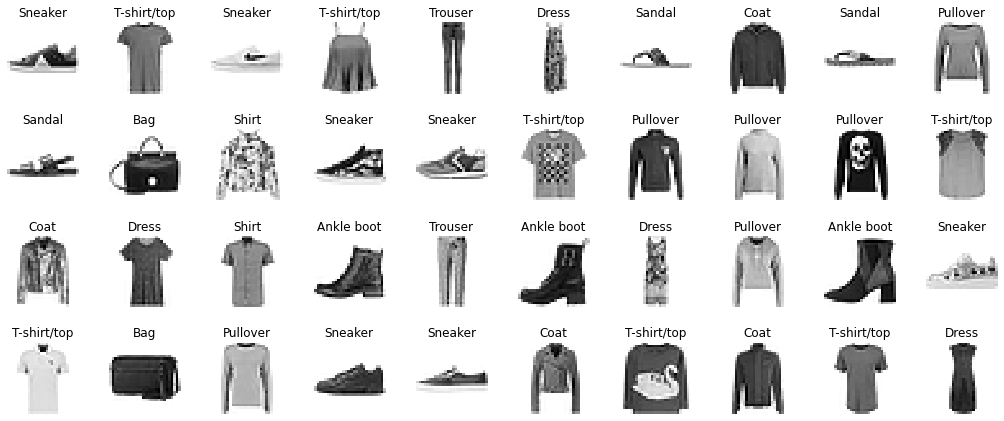

In [28]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.8, n_rows * 1.8))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [29]:
x_train = x_train.reshape(*x_train.shape[:1],-1)
x_test = x_test.reshape(*x_test.shape[:1],-1)

In [32]:
shirt_class = 6
y_train = (y_train == shirt_class).astype('int')
y_test = (y_test == shirt_class).astype('int')

# Visualizing the Dataset as a Point Cluster

In [34]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(x_train)
X_2d.shape, np.cumsum(pca.explained_variance_)

((6000, 2), array([20.15296684, 32.39902046]))

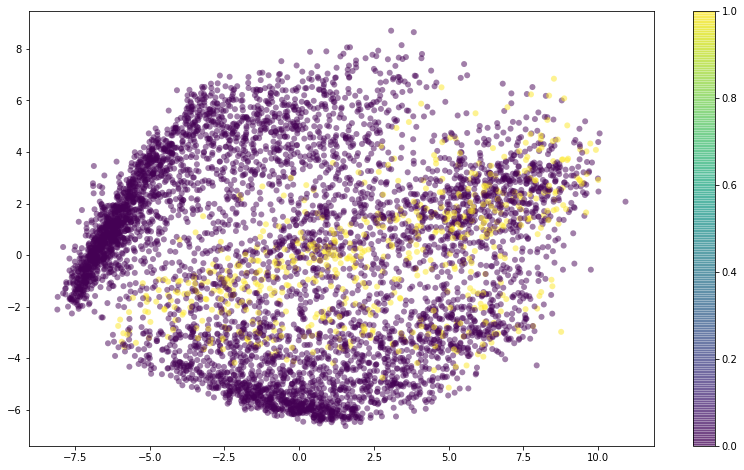

In [37]:
plt.figure(figsize=(14,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=y_train,edgecolor='none',alpha=0.5)
plt.colorbar()
plt.show()

# The Logistic Regression Model

As mentioned before, we will use multinary Logistic Regression to classify this dataset. This time we will scan across possibilities of regularization (L1 or ElasticNet) as well as candidate values for the regularization coefficients.

## Choosing Features

Our features will be the individual pixel values themselves. In particular, suppose an image $\mathcal{I}$ consists of pixels $p_{ij}$ located at position $ij$ on the image grid. Then our feature vector $\phi\left(\mathcal{I}\right)$ will be
\begin{equation}
\phi\left(\mathcal{I}\right)_k = p_{ij}, \qquad k \equiv \left(i,j\right)\,.
\end{equation}
Operationally, this means we can unroll the $2d$ images in <tt>x_train</tt> and <tt>x_test</tt> into $1d$ dimensional vectors which are then input into the Logistic Regression classifier.

In [38]:
softmax_reg = SGDClassifier(loss='log_loss',penalty='l1',alpha=1e-3,verbose=0)
softmax_reg.fit(x_train,y_train)

SGDClassifier(alpha=0.001, loss='log_loss', penalty='l1')

In [39]:
softmax_reg = SGDClassifier(loss='log_loss',penalty='l1',alpha=1e-3,verbose=0)

param_grid = [{'penalty':['l1','elasticnet'],'alpha':[1e-2,1e-3,1e-4,1e-5],'l1_ratio':[0.5,1e-1,1e-2]}]

gridsearch = GridSearchCV(softmax_reg,param_grid,cv=5)

gridsearch.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(alpha=0.001, loss='log_loss',
                                     penalty='l1'),
             param_grid=[{'alpha': [0.01, 0.001, 0.0001, 1e-05],
                          'l1_ratio': [0.5, 0.1, 0.01],
                          'penalty': ['l1', 'elasticnet']}])

In [40]:
final_model = gridsearch.best_estimator_
gridsearch.best_estimator_

SGDClassifier(alpha=0.001, l1_ratio=0.01, loss='log_loss', penalty='elasticnet')

In [121]:
y_tr_pred = gridsearch.predict(x_train)
print('accuracy reached on train set: ',accuracy_score(y_train,y_tr_pred))
print('matthews correlation coefficient on the train set: {:.3f}'.format(matthews_corrcoef(y_train,y_tr_pred)))

accuracy reached on train set:  0.9406666666666667
matthews correlation coefficient on the train set: 0.631


In [42]:
y_pred = gridsearch.predict(x_test)
print('accuracy reached on test set: ',accuracy_score(y_test,y_pred))
print('matthews correlation coefficient on the test set: {:.3f}'.format(matthews_corrcoef(y_test,y_pred)))

accuracy reached on test set:  0.916
matthews correlation coefficient on the test set: 0.445


# Enumerating Misclassifications
So far we have measured the performance of the classifier using the accuracy, i.e. the ratio of correct classifications to all classifications done. However, the high accuracies computed above may not be reflective of the actual performance of the classifier. This is also visible from computing the Matthews correlation function, which computes the correlation between the actual and predicted class labels and is insensitive to population imbalances in each class.

To get more insight, we open out the classifications performed. This involves computing the _confusion matrix_ $C$. The matrix element $C_{ij}$ denotes the number of elements that belong to class $i$ and are identified as belonging to class $j$ by the classifier. For a perfect classifier, the confusion matrix should be diagonal.

In [47]:
print('confusion matrix on train set')

confusionmatrix = confusion_matrix(y_train,y_tr_pred)
print(confusionmatrix)

print('confusion matrix on test set')

confusionmatrix = confusion_matrix(y_test,y_pred)
print(confusionmatrix)

confusion matrix on train set
[[5314   86]
 [ 270  330]]
confusion matrix on test set
[[879  21]
 [ 63  37]]


# Precision, Recall, Fscore

A popular metric to characterize the performance of a classifier is the _accuracy_, which is the ratio of all correct predictions to the total number of predictions. Depending on the application at hand, this metric may not always be the best choice. For example, consider the Fashion MNIST problem where we are given the reduced binary problem of distinguishing between shirts and everything else. Simply by blindly outputting 'not a shirt', a classifier can reach 90\% accuracy. A more exhaustive discussion of accuracy vs other performance metrics is available [here](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models). 

For this notebook we will focus on some metrics which can be arrived at from enumerating true positives <b>(TP)</b>, true negatives <b>(TN)</b>, false positives <b>(FP)</b>, false negatives <b>(FN)</b>. A perfectly functioning classifier will have only true positives and true negatives, there will be no false positives or negatives. This is also when the accuracy will be 100\%.
1. _precision :_ 
\begin{equation} p = \frac{TP}{TP+FP} \end{equation}
i.e. the number of true positives in all detected positive.
2. _recall :_ For the i-th class
\begin{equation} r = \frac{TP}{TP+FN} \end{equation}
i.e. encodes the number of positives missed by the classifier.

We can also organize precision and recall into a single number, the F1 score.
\begin{equation} f_{1} = 2\frac{p*r}{p+r} \end{equation}
We now compute the precision, recall and f1 scores of the SGDClassifier trained on the Fashion MNIST data.

In [52]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_tr_pred), recall_score(y_train, y_tr_pred)

(0.7932692307692307, 0.55)

In [49]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, y_tr_pred, average=None)

print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('f1score : {}'.format(f1score))

precision : [0.95164756 0.79326923]
recall : [0.98407407 0.55      ]
f1score : [0.96758922 0.6496063 ]


In [50]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('f1score : {}'.format(f1score))

precision : [0.93312102 0.63793103]
recall : [0.97666667 0.37      ]
f1score : [0.95439739 0.46835443]


From these numbers we see that characterizing performance in terms of accuracy may not always be reflective of the classifier performance in the presence of skewed datasets. Precision and Recall are better at characterizing the performance in such cases, and qualitatively at least, seem to give us similar information as the Matthews Coefficient, which the accuracy misses.

In addition, it might be that we wish to tune the prediction/inference step further in classification. For example, in applications such as disease detection one might wish to drive down the number of false negatives output by the classifier. In other applications such as spam mail detection one might wish to drive down false positives detected by the classifier. Clearly, precision and recall are useful metrics for these purposes as well. The spam case corresponds to high precision and the
disease case corresponds to high recall.

<b><u>Precision Recall Tradeoff</u></b>.

Intuitively it seems clear that improving precision likely comes at the expense of worsening recall and vice vera. If we make the classifier more permissive, so that it starts to raise fewer false negatives, it could come at the expense of allowing greater false positives as well. That is, increasing recall would tend to decrease precision. Conversely, if the classifier is stricter, and cracks down on the number of false positives, it could come at the expense of discarding more images falsely as negative. i.e. increasing precision would tend to decrease recall.

This is known as the precision recall tradeoff. We now turn to characterizing this tradeoff.

In order to do so, note that scikit-learn classifiers typically have the methods <b>predict_proba</b>, which predicts the probabilties of a given input to belong to each class. In binary classification there are only two classes, and hence, one independent probability. By default, the input is assigned the class for which the probability is higher than the _threshold_ of 0.5. We can use these probabilities along with sklearn functions to compute the _precision recall curve_ as below.

In [108]:
y_tr_proba = gridsearch.predict_proba(x_train)
y_tr_proba.shape

(6000, 2)

In [109]:
precision, recall, threshold = precision_recall_curve(y_train,y_tr_proba[:,1])

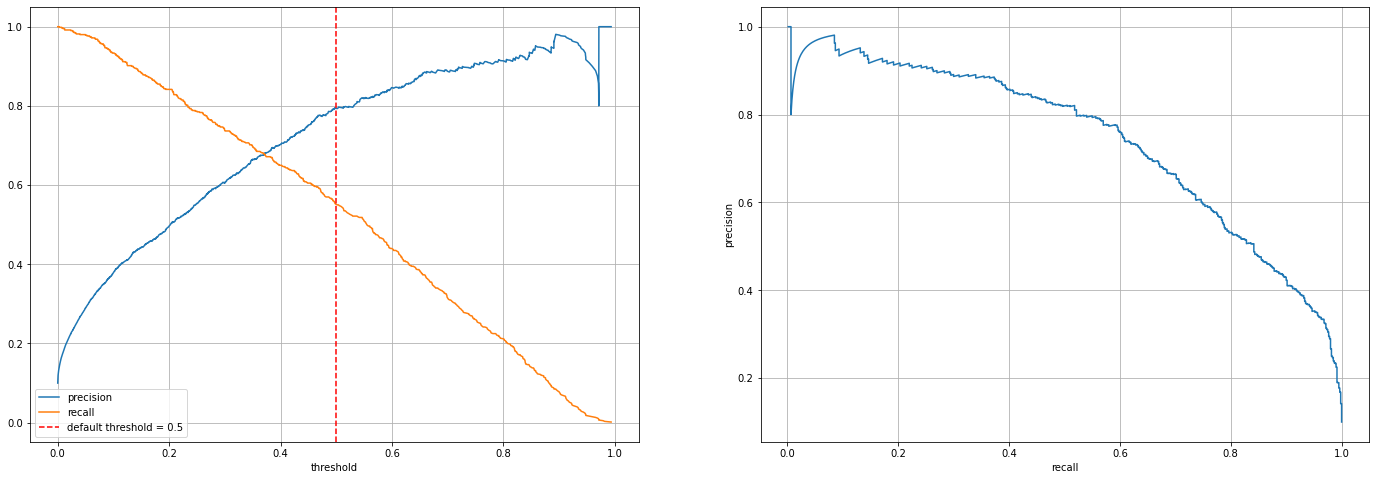

In [110]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
plt.plot(threshold,precision[:-1],label='precision')
plt.plot(threshold,recall[:-1],label='recall')
plt.axvline(x=0.5,color='r',linestyle='--',label='default threshold = 0.5')
plt.xlabel('threshold')
plt.grid('both')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(recall[:-1],precision[:-1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid('both')
plt.show()

sklearn classifiers also have a <b>decision_function</b> method which computes a score for the given input for each class, and when the score passes a threshold, the input is assigned to that class. We can also use this score to compute the precision recall curves and we get the same thing as above.

In [73]:
y_tr_score = gridsearch.decision_function(x_train)
precision, recall, threshold = precision_recall_curve(y_train,y_tr_score)

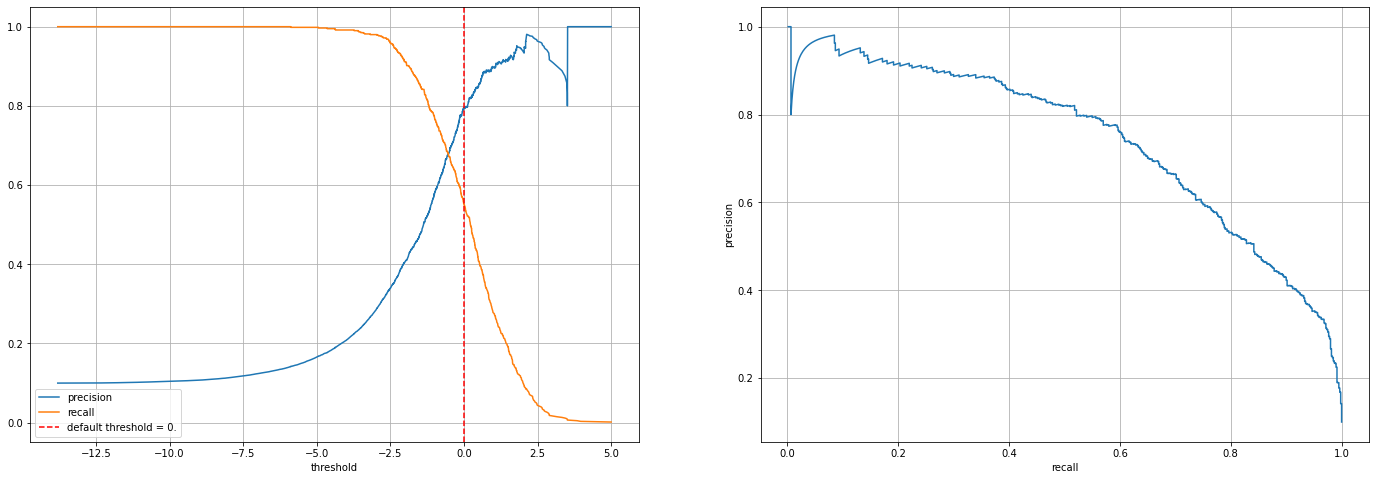

In [75]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
plt.plot(threshold,precision[:-1],label='precision')
plt.plot(threshold,recall[:-1],label='recall')
plt.axvline(x=0.,color='r',linestyle='--',label='default threshold = 0.')
plt.xlabel('threshold')
plt.grid('both')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(recall[:-1],precision[:-1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid('both')
plt.show()

The above curves clearly make the precision recall tradeoff manifest. Increasing either precision or recall comes at the cost of decreasing the other quantity.

# Varying Precision and Recall

We have seen that with the default threshold of 0.5 we get a recall of 0.55 at a precision of 0.79. Suppose we now try to increase recall to more that 0.8, so that as few false negatives are discarded as possible. Looking at the precision recall curves this seems to correspond to setting threshold to 0.2 when using the probability scores. It also seems that precision will go down to about 50/%.

In [118]:
y_tr_pred_varied_proba = (y_tr_proba[:,1] >= 0.2).astype('int')

In [119]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, 
                                                                y_tr_pred_varied_proba, 
                                                                average=None)

print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('f1score : {}'.format(f1score))

precision : [0.98093518 0.49655851]
recall : [0.90518519 0.84166667]
f1score : [0.94153905 0.62461348]


In [120]:
print('confusion matrix on train set')

confusionmatrix = confusion_matrix(y_train,y_tr_pred_varied_proba)
print(confusionmatrix)

confusion matrix on train set
[[4888  512]
 [  95  505]]


Now we can implement this on the test set.

In [117]:
y_te_proba = gridsearch.predict_proba(x_test)
y_te_pred_varied_proba = (y_te_proba[:,1] >= 0.2).astype('int')
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, 
                                                                y_te_pred_varied_proba, 
                                                                average=None)

print('precision : {}'.format(precision))
print('recall : {}'.format(recall))
print('f1score : {}'.format(f1score))

print('confusion matrix on test set')

confusionmatrix = confusion_matrix(y_test,y_te_pred_varied_proba)
print(confusionmatrix)

precision : [0.96359223 0.39772727]
recall : [0.88222222 0.7       ]
f1score : [0.92111369 0.50724638]
confusion matrix on test set
[[794 106]
 [ 30  70]]


# ROC Curve
Another measure of how well a classifier works is the _receiver operator characterestic_ (ROC) curve. This plots the _true positive rate_ (TPR) vs the _false positive
rate_, defined as
\begin{equation}
TPR = \frac{TP}{TP+FN}\,, \qquad FPR = \frac{FP}{FP+TN}\,.
\end{equation}
Note that TPR is the same as recall. Again, as the classifier becomes more permissive, the number of false negatives 

Ideally, a classifier should have TPR of 1 while FPR is 0. The ROC curve of such a classifier corresponds to the blue dotted line in the figure below.

A random classifier on the other hand will have an ROC curve of a straight line from (0,0) to (1,1) as explained [here](https://datascience.stackexchange.com/questions/31872/auc-roc-of-a-random-classifier).

In [84]:
y_tr_score = gridsearch.predict_proba(x_train)

fpr, tpr, threshold = roc_curve(y_train,y_tr_score[:,1])

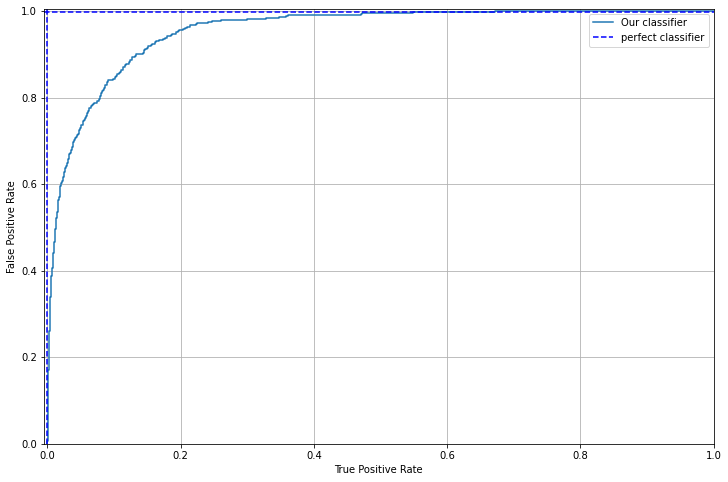

In [106]:
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label='Our classifier')
plt.axvline(x=0.,c='b',linestyle='--',label='perfect classifier')
plt.axhline(y=1-1e-3,c='b',linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.xlim([0-5e-3,1])
plt.ylim([0,1+5e-3])
plt.grid('both')
plt.legend(loc='best')
plt.show()

Another useful measure of the performance of the classifier is the _area under curve_ for the ROC curve. From the respective forms of the ROC curves it is clear that an ideal classifier will have AUC = 1, while a random classifier will have AUC = 0.5.

In [107]:
auc_sgd=roc_auc_score(y_train,y_tr_score[:,1])
print('area under curve for our classifier : ', auc_sgd)

area under curve for our classifier :  0.9542157407407407
